In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 64

model_name = "ResNet50"


In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.8

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:
# ResNet-34モデルの定義
class CustomResNet50(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet50, self).__init__()
        self.resnet = models.resnet50(weights="IMAGENET1K_V1")  # 事前学習済みのResNet-34モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [9]:
# 2. モデルの構築
model = CustomResNet50(num_classes=5).to(device)


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s]


Epoch 1/50, Train Loss: 0.7074530776941551, Val Loss: 1.2082936806338174, Train Acc: 0.7434115262090936, Val Acc: 0.6828703703703703


Epoch 2/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


Epoch 2/50, Train Loss: 0.4923989935865942, Val Loss: 0.6939821434872491, Train Acc: 0.8108890819577179, Val Acc: 0.7592592592592593


Epoch 3/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s]


Epoch 3/50, Train Loss: 0.41592939085555525, Val Loss: 0.666587987116405, Train Acc: 0.8363741673906748, Val Acc: 0.8125


Epoch 4/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.17it/s]


Epoch 4/50, Train Loss: 0.3850428563243938, Val Loss: 0.3402567729353905, Train Acc: 0.8439038517231393, Val Acc: 0.8726851851851852


Epoch 5/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.61it/s]


Epoch 5/50, Train Loss: 0.32516512837050093, Val Loss: 0.8288279346057347, Train Acc: 0.8673617144512018, Val Acc: 0.7384259259259259


Epoch 6/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.69it/s]


Epoch 6/50, Train Loss: 0.28981359752843966, Val Loss: 0.3720471199069704, Train Acc: 0.878945844193455, Val Acc: 0.8668981481481481


Epoch 7/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.49it/s]


Epoch 7/50, Train Loss: 0.2895646159941295, Val Loss: 0.3643174607838903, Train Acc: 0.8806834636547929, Val Acc: 0.8692129629629629


Epoch 8/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.47it/s]


Epoch 8/50, Train Loss: 0.26568678091719466, Val Loss: 0.511524423956871, Train Acc: 0.8899507674485955, Val Acc: 0.8495370370370371


Epoch 9/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.47it/s]


Epoch 9/50, Train Loss: 0.23379887331206844, Val Loss: 0.36214675647871836, Train Acc: 0.9015348971908486, Val Acc: 0.8807870370370371


Epoch 10/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.47it/s]


Epoch 10/50, Train Loss: 0.2606932059773859, Val Loss: 0.49423503237111227, Train Acc: 0.8905299739357081, Val Acc: 0.8460648148148148


Epoch 11/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.50it/s]


Epoch 11/50, Train Loss: 0.21326223599179736, Val Loss: 0.3250029262687479, Train Acc: 0.9084853750362004, Val Acc: 0.8773148148148148


Epoch 12/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.47it/s]


Epoch 12/50, Train Loss: 0.2029188244410281, Val Loss: 0.5618724524974823, Train Acc: 0.915146249637996, Val Acc: 0.8553240740740741


Epoch 13/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.47it/s]


Epoch 13/50, Train Loss: 0.21286168061899688, Val Loss: 0.49122099791254314, Train Acc: 0.9081957717926441, Val Acc: 0.8449074074074074


Epoch 14/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.45it/s]


Epoch 14/50, Train Loss: 0.1812204787472509, Val Loss: 0.41617480559008463, Train Acc: 0.9180422820735592, Val Acc: 0.8587962962962963


Epoch 15/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.40it/s]


Epoch 15/50, Train Loss: 0.19273059955745372, Val Loss: 0.44213152144636425, Train Acc: 0.9186214885606718, Val Acc: 0.8645833333333334


Epoch 16/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.19it/s]


Epoch 16/50, Train Loss: 0.17996693557163454, Val Loss: 0.3284017454300608, Train Acc: 0.9218071242397915, Val Acc: 0.8946759259259259


Epoch 17/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  5.73it/s]


Epoch 17/50, Train Loss: 0.1455906648540272, Val Loss: 0.42372808179685045, Train Acc: 0.931074428033594, Val Acc: 0.8622685185185185


Epoch 18/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.27it/s]


Epoch 18/50, Train Loss: 0.1350539079252279, Val Loss: 0.41193873807787895, Train Acc: 0.9371560961482769, Val Acc: 0.8784722222222222


Epoch 19/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.65it/s]


Epoch 19/50, Train Loss: 0.11678341438747802, Val Loss: 0.4524396540863173, Train Acc: 0.9432377642629598, Val Acc: 0.8657407407407407


Epoch 20/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.50it/s]


Epoch 20/50, Train Loss: 0.14129797608222602, Val Loss: 0.33989720046520233, Train Acc: 0.9336808572256009, Val Acc: 0.8946759259259259


Epoch 21/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 21/50, Train Loss: 0.11304365948967214, Val Loss: 0.2867398794208254, Train Acc: 0.9409209383145091, Val Acc: 0.9097222222222222


Epoch 22/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s]


Epoch 22/50, Train Loss: 0.10729504418822955, Val Loss: 0.46345083841255735, Train Acc: 0.9455545902114104, Val Acc: 0.8518518518518519


Epoch 23/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 23/50, Train Loss: 0.10452125319894755, Val Loss: 0.3744427572403635, Train Acc: 0.945264986967854, Val Acc: 0.8831018518518519


Epoch 24/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 24/50, Train Loss: 0.10478692174941864, Val Loss: 0.5443471946886608, Train Acc: 0.9455545902114104, Val Acc: 0.8564814814814815


Epoch 25/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s]


Epoch 25/50, Train Loss: 0.08464615440593576, Val Loss: 0.34339430475873606, Train Acc: 0.9533738777874312, Val Acc: 0.9085648148148148


Epoch 26/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.51it/s]


Epoch 26/50, Train Loss: 0.1041994100823155, Val Loss: 0.39691009159599033, Train Acc: 0.9472922096727483, Val Acc: 0.8784722222222222


Epoch 27/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s]


Epoch 27/50, Train Loss: 0.113047726223913, Val Loss: 0.35647607488291605, Train Acc: 0.9458441934549667, Val Acc: 0.8958333333333334


Epoch 28/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s]


Epoch 28/50, Train Loss: 0.09795327470549997, Val Loss: 0.3770482859441212, Train Acc: 0.947871416159861, Val Acc: 0.8912037037037037


Epoch 29/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


Epoch 29/50, Train Loss: 0.09251531673911607, Val Loss: 0.4579349160194397, Train Acc: 0.950477845351868, Val Acc: 0.8831018518518519


Epoch 30/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s]


Epoch 30/50, Train Loss: 0.09379460848867893, Val Loss: 0.39844432579619543, Train Acc: 0.952215464813206, Val Acc: 0.8958333333333334


Epoch 31/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


Epoch 31/50, Train Loss: 0.09129056548875458, Val Loss: 0.43381424700575216, Train Acc: 0.950477845351868, Val Acc: 0.8726851851851852


Epoch 32/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 32/50, Train Loss: 0.10425466712001923, Val Loss: 0.33604202046990395, Train Acc: 0.947871416159861, Val Acc: 0.8958333333333334


Epoch 33/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.52it/s]


Epoch 33/50, Train Loss: 0.11288454974035048, Val Loss: 0.2822814541203635, Train Acc: 0.9498986388647553, Val Acc: 0.8981481481481481


Epoch 34/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.55it/s]


Epoch 34/50, Train Loss: 0.06885883263048698, Val Loss: 0.32133382133075167, Train Acc: 0.9614827686070084, Val Acc: 0.9085648148148148


Epoch 35/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


Epoch 35/50, Train Loss: 0.060850447922382714, Val Loss: 0.35875351460916655, Train Acc: 0.96293078482479, Val Acc: 0.9085648148148148


Epoch 36/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


Epoch 36/50, Train Loss: 0.08566871591193496, Val Loss: 0.40357606006520136, Train Acc: 0.9545322907616566, Val Acc: 0.8935185185185185


Epoch 37/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 37/50, Train Loss: 0.06238175352227013, Val Loss: 0.4142839339162622, Train Acc: 0.9632203880683463, Val Acc: 0.8935185185185185


Epoch 38/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]


Epoch 38/50, Train Loss: 0.06279126057875747, Val Loss: 0.6829437421900886, Train Acc: 0.9617723718505647, Val Acc: 0.8425925925925926


Epoch 39/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


Epoch 39/50, Train Loss: 0.09700604898960523, Val Loss: 0.5404581491436277, Train Acc: 0.9498986388647553, Val Acc: 0.8692129629629629


Epoch 40/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


Epoch 40/50, Train Loss: 0.07386345140425102, Val Loss: 0.483079517526286, Train Acc: 0.9556907037358818, Val Acc: 0.8842592592592593


Epoch 41/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.59it/s]


Epoch 41/50, Train Loss: 0.0680173594539739, Val Loss: 0.3639371416398457, Train Acc: 0.9611931653634521, Val Acc: 0.8993055555555556


Epoch 42/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.57it/s]


Epoch 42/50, Train Loss: 0.05478397626781239, Val Loss: 0.37987389309065683, Train Acc: 0.9632203880683463, Val Acc: 0.8993055555555556


Epoch 43/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 43/50, Train Loss: 0.0510949416982256, Val Loss: 0.3671021871268749, Train Acc: 0.9643788010425717, Val Acc: 0.9143518518518519


Epoch 44/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]


Epoch 44/50, Train Loss: 0.04240164422992406, Val Loss: 0.32698019966483116, Train Acc: 0.9687228496959166, Val Acc: 0.9155092592592593


Epoch 45/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]


Epoch 45/50, Train Loss: 0.04703761956144897, Val Loss: 0.4495197172675814, Train Acc: 0.968143643208804, Val Acc: 0.8923611111111112


Epoch 46/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]


Epoch 46/50, Train Loss: 0.0803371998569313, Val Loss: 0.4673378723008292, Train Acc: 0.9536634810309875, Val Acc: 0.8738425925925926


Epoch 47/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.58it/s]


Epoch 47/50, Train Loss: 0.06782384893312207, Val Loss: 0.44521951356104444, Train Acc: 0.9603243556327831, Val Acc: 0.9039351851851852


Epoch 48/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s]


Epoch 48/50, Train Loss: 0.056749657661882495, Val Loss: 0.3503986671566963, Train Acc: 0.9640891977990154, Val Acc: 0.9039351851851852


Epoch 49/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.54it/s]


Epoch 49/50, Train Loss: 0.032572298767572304, Val Loss: 0.36636962422302793, Train Acc: 0.9716188821314798, Val Acc: 0.9085648148148148


Epoch 50/50, Validation...: 100%|██████████| 14/14 [00:02<00:00,  6.56it/s]

Epoch 50/50, Train Loss: 0.0348314787261188, Val Loss: 0.5237024096505982, Train Acc: 0.9713292788879235, Val Acc: 0.8854166666666666


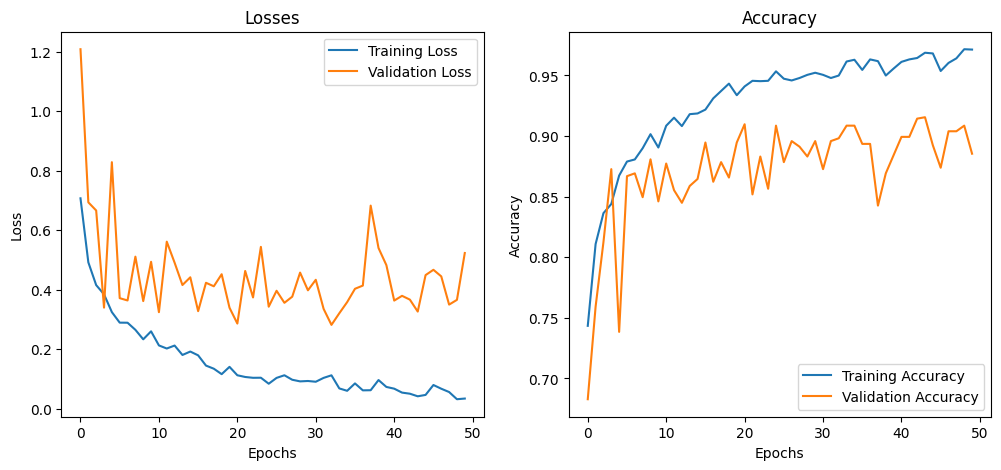

In [13]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
